In [1]:
# flake8: noqa: E302

import gzip
import os
import shutil

import requests


def download_and_extract_dataset(url, save_path, folder_path):
    """Download and extract dataset if it doesn't exist."""
    if not os.path.exists(save_path):
        print(f"Downloading {os.path.basename(save_path)}...")
        response = requests.get(url)
        with open(save_path, "wb") as file:
            file.write(response.content)

        decompressed_file_name = os.path.splitext(os.path.basename(save_path))[0]
        decompressed_file_path = os.path.join(folder_path, decompressed_file_name)

        with gzip.open(save_path, "rb") as f_in:
            with open(decompressed_file_path, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)

        print(f"{decompressed_file_name} downloaded and extracted.")
    else:
        print(f"{os.path.basename(save_path)} already exists.")


file_info = [
    (
        "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
        "train-images-idx3-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
        "train-labels-idx1-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
        "t10k-images-idx3-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz",
        "t10k-labels-idx1-ubyte.gz",
    ),
]

folder_name = "tmp/mnist"
folder_path = os.path.join(os.getcwd(), folder_name)

os.makedirs(folder_path, exist_ok=True)  # Create folder if it doesn't exist

# Download and extract each file
for url, file_name in file_info:
    path_to_save = os.path.join(folder_path, file_name)
    download_and_extract_dataset(url, path_to_save, folder_path)

# %%
import numpy as np


def read_idx3_ubyte_image_file(filename):
    """Read IDX3-ubyte formatted image data."""
    with open(filename, "rb") as f:
        magic_num = int.from_bytes(f.read(4), byteorder="big")
        num_images = int.from_bytes(f.read(4), byteorder="big")
        num_rows = int.from_bytes(f.read(4), byteorder="big")
        num_cols = int.from_bytes(f.read(4), byteorder="big")

        if magic_num != 2051:
            raise ValueError(f"Invalid magic number: {magic_num}")

        images = np.zeros((num_images, num_rows, num_cols), dtype=np.uint8)

        for i in range(num_images):
            for r in range(num_rows):
                for c in range(num_cols):
                    pixel = int.from_bytes(f.read(1), byteorder="big")
                    images[i, r, c] = pixel

    return images


def read_idx1_ubyte_label_file(filename):
    """Read IDX1-ubyte formatted label data."""
    with open(filename, "rb") as f:
        magic_num = int.from_bytes(f.read(4), byteorder="big")
        num_labels = int.from_bytes(f.read(4), byteorder="big")

        if magic_num != 2049:
            raise ValueError(f"Invalid magic number: {magic_num}")

        labels = np.zeros(num_labels, dtype=np.uint8)

        for i in range(num_labels):
            labels[i] = int.from_bytes(f.read(1), byteorder="big")

    return labels


# Example usage
folder_path = os.path.join(
    os.getcwd(), folder_name
)  # Adjust this path to where you stored the files

train_images = read_idx3_ubyte_image_file(
    os.path.join(folder_path, "train-images-idx3-ubyte")
)
train_labels = read_idx1_ubyte_label_file(
    os.path.join(folder_path, "train-labels-idx1-ubyte")
)
test_images = read_idx3_ubyte_image_file(
    os.path.join(folder_path, "t10k-images-idx3-ubyte")
)
test_labels = read_idx1_ubyte_label_file(
    os.path.join(folder_path, "t10k-labels-idx1-ubyte")
)

print(
    f"Shape of train_images: {train_images.shape}"
)  # Should output "Shape of train_images: (60000, 28, 28)"
print(
    f"Shape of train_labels: {train_labels.shape}"
)  # Should output "Shape of train_labels: (60000,)"
print(
    f"Shape of test_images: {test_images.shape}"
)  # Should output "Shape of test_images: (10000, 28, 28)"
print(
    f"Shape of test_labels: {test_labels.shape}"
)  # Should output "Shape of test_labels: (10000,)"

# %%
# Reshape the datasets from 3D to 2D
train_images_2d = train_images.reshape(
    train_images.shape[0], -1
)  # -1 infers the size from the remaining dimensions
test_images_2d = test_images.reshape(test_images.shape[0], -1)

train-images-idx3-ubyte.gz already exists.
train-labels-idx1-ubyte.gz already exists.
t10k-images-idx3-ubyte.gz already exists.
t10k-labels-idx1-ubyte.gz already exists.
Shape of train_images: (60000, 28, 28)
Shape of train_labels: (60000,)
Shape of test_images: (10000, 28, 28)
Shape of test_labels: (10000,)


In [2]:
# convertto pytorch tensors
import torch

train_images_tensor_initial = torch.from_numpy(train_images_2d).float()
train_labels_tensor_initial = torch.from_numpy(train_labels).long()
test_images_tensor = torch.from_numpy(test_images_2d).float()
test_labels_tensor = torch.from_numpy(test_labels).long()

# seed the random number generator
torch.manual_seed(0)

# shuffle the training dataset
indices = torch.randperm(train_images_tensor_initial.shape[0])
train_images_tensor_shuffled = train_images_tensor_initial[indices]
train_labels_tensor_shuffled = train_labels_tensor_initial[indices]

# get a 10% validation set
validation_size = int(train_images_tensor_shuffled.shape[0] * 0.1)
validation_images_tensor = train_images_tensor_shuffled[:validation_size]
validation_labels_tensor = train_labels_tensor_shuffled[:validation_size]
train_images_tensor = train_images_tensor_shuffled[validation_size:]
train_labels_tensor = train_labels_tensor_shuffled[validation_size:]

In [3]:
print(train_labels_tensor.shape)
print(validation_labels_tensor.shape)
print(train_labels_tensor_initial.shape)
print(train_labels_tensor_shuffled.shape)
print(validation_size)

torch.Size([54000])
torch.Size([6000])
torch.Size([60000])
torch.Size([60000])
6000


In [4]:
print("Initial training labels size:", train_labels_tensor_initial.shape[0])
print("Validation set size:", validation_size)
print("Validation labels size after split:", validation_labels_tensor.shape[0])
print("Training labels size after split:", train_labels_tensor.shape[0])

Initial training labels size: 60000
Validation set size: 6000
Validation labels size after split: 6000
Training labels size after split: 54000


## Plot an image

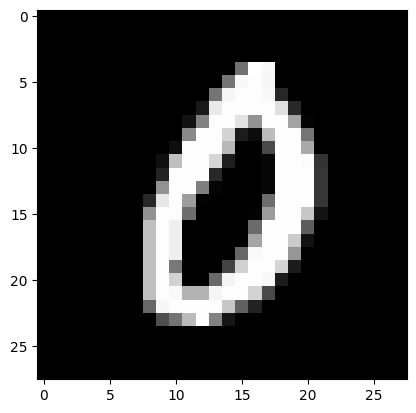

Image shape torch.Size([28, 28])
Label tensor(0)


In [5]:
image_id = 0

image = train_images_tensor[image_id].reshape(28, 28)

import matplotlib.pyplot as plt

plt.imshow(image, cmap="gray")
plt.show()

print("Image shape", image.shape)

print("Label", train_labels_tensor[image_id])

## Get a bounding box of the image

In [6]:
import numpy as np


def get_bounding_box(img):
    """
    Extract the bounding box from an MNIST image.

    Args:
        img (np.ndarray): 2D numpy array representing the MNIST image.

    Returns:
        (np.ndarray): Cropped image with the bounding box.
    """

    # convert torch image to numpy array
    img = img.numpy()

    # Find the rows and columns where the image has non-zero pixels
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)

    # Find the first and last row and column indices where the image has non-zero pixels
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    # Return the cropped image
    return img[rmin : rmax + 1, cmin : cmax + 1]

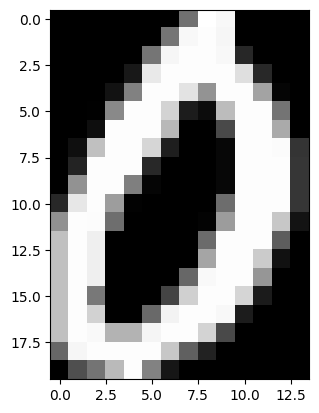

Image shape (20, 14)
Label tensor(0)


In [7]:
image = train_images_tensor[image_id].reshape(28, 28)
cropped_image = get_bounding_box(image)

plt.imshow(cropped_image, cmap="gray")
plt.show()

print("Image shape", cropped_image.shape)

print("Label", train_labels_tensor[image_id])

## Make the image quadratic (20x20)

In [8]:
import cv2

cropped_image_uint8 = np.clip(cropped_image, 0, 255).astype(np.uint8)
resized_image = cv2.resize(cropped_image_uint8, (20, 20), interpolation=cv2.INTER_AREA)

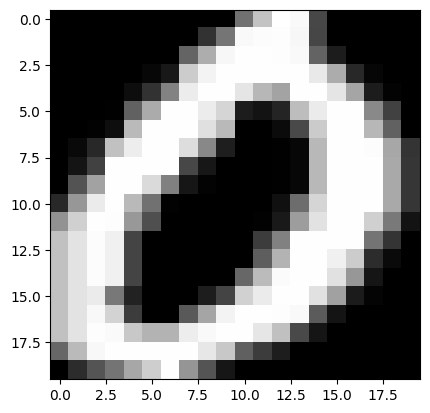

Image shape (20, 20)
Label tensor(0)


In [9]:
plt.imshow(resized_image, cmap="gray")
plt.show()

print("Image shape", resized_image.shape)

print("Label", train_labels_tensor[image_id])

## Create a reshaped image dataset

In [10]:
num_train = len(train_images_tensor)

train_images_tensor_resized = np.zeros((num_train, 400))

for i in range(num_train):
    cropped_image = get_bounding_box(train_images_tensor[i].reshape(28, 28))
    cropped_image_uint8 = np.clip(cropped_image, 0, 255).astype(np.uint8)
    resized_image = cv2.resize(
        cropped_image_uint8, (20, 20), interpolation=cv2.INTER_AREA
    )
    train_images_tensor_resized[i, :] = resized_image.flatten()

num_test = len(test_images_tensor)

num_val = len(validation_images_tensor)

validation_images_tensor_resized = np.zeros((num_val, 400))

for i in range(num_val):
    cropped_image = get_bounding_box(validation_images_tensor[i].reshape(28, 28))
    cropped_image_uint8 = np.clip(cropped_image, 0, 255).astype(np.uint8)
    resized_image = cv2.resize(
        cropped_image_uint8, (20, 20), interpolation=cv2.INTER_AREA
    )
    validation_images_tensor_resized[i, :] = resized_image.flatten()

num_test = len(test_images_tensor)

test_images_tensor_resized = np.zeros((num_test, 400))

for i in range(num_test):
    cropped_image = get_bounding_box(test_images_tensor[i].reshape(28, 28))
    cropped_image_uint8 = np.clip(cropped_image, 0, 255).astype(np.uint8)
    resized_image = cv2.resize(
        cropped_image_uint8, (20, 20), interpolation=cv2.INTER_AREA
    )
    test_images_tensor_resized[i, :] = resized_image.flatten()

## Normalize all datasets

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features_normalized = torch.tensor(scaler.fit_transform(train_images_tensor))
val_features_normalized = torch.tensor(scaler.transform(validation_images_tensor))
test_features_normalized = torch.tensor(scaler.transform(test_images_tensor))

train_features_resized_normalized = torch.tensor(
    scaler.fit_transform(train_images_tensor_resized)
)
val_features_resized_normalized = torch.tensor(
    scaler.transform(validation_images_tensor_resized)
)
test_features_resized_normalized = torch.tensor(
    scaler.transform(test_images_tensor_resized)
)

In [12]:
train_features_normalized = train_features_normalized.float()
val_features_normalized = val_features_normalized.float()
test_features_normalized = test_features_normalized.float()

train_features_resized_normalized = train_features_resized_normalized.float()
val_features_resized_normalized = val_features_resized_normalized.float()
test_features_resized_normalized = test_features_resized_normalized.float()

## Try out a medium-sized neural network

In [13]:
# define code to measure accuracy

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

## Let's try the resized images

## Look into haar features

In [14]:
def compute_haar_features(image):
    if image.shape != (20, 20) and image.shape != (28, 28):
        raise ValueError("Input image must be of shape 20x20 or 28x28.")

    features = []

    # Sliding window
    for i in range(0, image.shape[0], 3):  # Slide vertically with a step of 3
        for j in range(0, image.shape[0], 3):  # Slide horizontally with a step of 3

            if i + 6 > image.shape[0] or j + 6 > image.shape[0]:
                continue

            # Extract 6x6 window
            window = image[i : i + 6, j : j + 6]

            # Horizontal feature
            horizontal_feature_value = np.sum(window[0:3, :]) - np.sum(window[3:6, :])

            # Vertical feature
            vertical_feature_value = np.sum(window[:, 0:3]) - np.sum(window[:, 3:6])

            features.append(horizontal_feature_value)
            features.append(vertical_feature_value)

    return np.array(features)

In [15]:
haar_1 = compute_haar_features(train_images_tensor[0].reshape(28, 28).numpy())
print(haar_1)
len_haar_features = len(haar_1)
print("length of a haar feature for 28x28 images", len_haar_features)

[    0.     0.     0.     0.     0.     0.  -117.  -117. -1480. -1246.
 -1363.  1363.     0.     0.     0.     0.     0.     0.     0.     0.
   -18.   -18. -1409. -1607. -2169. -1879. -1502.  2780.  -724.   724.
     0.     0.     0.     0.     0.     0.  -847.  -883. -1244. -2530.
  1435.   963.   501.  -329. -1384.  2726.   -53.    53.     0.     0.
   -41.   -41. -1010. -2658.   508.   366.  1663.  1901.   -36. -3900.
  -331.  4117.  -109.   215.     0.     0.  -488.  -570.  -253. -2863.
   663.  3005.  -386.  -632.  -314. -2994.   643.  3873.   143.   181.
     0.     0.   -47. -1105.   224. -1822.  -145.  2511. -1552. -2594.
   -30.   562.  1125.  2429.    19.    19.     0.     0.   281.  -871.
  -205. -2271. -1857.   939.    35.  -537.  2077.  2069.   671.   671.
     0.     0.     0.     0.   295.  -295.  2109. -1519.  3601.    27.
  2454.  1120.   667.   667.     0.     0.     0.     0.]
length of a haar feature for 28x28 images 128


In [16]:
haar_1 = compute_haar_features(train_images_tensor_resized[0].reshape(20, 20))
print(haar_1)
len_haar_features_resized = len(haar_1)
print("length of a haar feature for 20x20 images", len_haar_features_resized)

[ -339.  -339. -1844. -1810. -1511. -1207.  -131.  -249. -1376.  2298.
 -1690. -2094. -1410. -1280.  1610.  1616.  2663.  -639.   271.  -949.
 -1000. -2236.  1667.  1809.  1742.  1622.   -53. -1387.  -292. -2832.
    98.   608.   988.  2522.  -288.  -292. -1582. -2562.  -412.  -726.
  -110.  2028. -1076.  1026. -2496. -1492. -1082. -1242.  1760.  1966.]
length of a haar feature for 20x20 images 50


## Further simple features

In [17]:
def aspect_ratio(image, threshold=0.5):
    # Threshold the image to create a binary representation
    bin_image = image > threshold
    # Find the bounding box
    row_indices, col_indices = np.nonzero(bin_image)
    max_row, min_row = np.max(row_indices), np.min(row_indices)
    max_col, min_col = np.max(col_indices), np.min(col_indices)

    # Calculate the aspect ratio of the bounding box
    width = max_col - min_col + 1
    height = max_row - min_row + 1

    if height == 0:  # To avoid division by zero
        return 1.0

    return width / height


from scipy.ndimage import label as nd_label


def num_regions_below_threshold(image, threshold=0.5):
    # Threshold the image so that pixels below the threshold are set to 1
    # and those above the threshold are set to 0.
    bin_image = image < threshold

    # Use connected components labeling
    labeled_array, num_features = nd_label(bin_image)

    # Return the number of unique regions
    # (subtracting 1 as one of the labels will be the background)
    return num_features

from skimage.measure import label, regionprops
import numpy as np

def eccentricity(image, threshold=0.5):
    bin_image = image > threshold
    labeled_img = label(bin_image)
    properties = regionprops(labeled_img)
    if properties:
        return properties[0].eccentricity
    return 0

def extent(image, threshold=0.5):
    bin_image = image > threshold
    object_area = np.sum(bin_image)
    _, _, width, height = cv2.boundingRect(bin_image.astype(np.uint8))
    bounding_box_area = width * height
    return object_area / bounding_box_area if bounding_box_area != 0 else 0

import cv2

def edge_density(image):
    edges = cv2.Canny(image.astype(np.uint8), 100, 200)
    return np.sum(edges) / (image.shape[0] * image.shape[1])

def circularity(image, threshold=0.5):
    bin_image = image > threshold
    contours, _ = cv2.findContours(bin_image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    perimeter = cv2.arcLength(contours[0], True)
    area = np.sum(bin_image)
    if area == 0:
        return 0
    return (perimeter**2) / area


In [32]:
import numpy as np
import cv2
from skimage.morphology import skeletonize
from scipy.stats import skew

def bounding_box_ratio(image):
    # Find the bounding box
    y, x = np.where(image == 0)  # Assuming the digit is black (0) on a white (255) background
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    
    bb_width = x_max - x_min
    bb_height = y_max - y_min
    
    image_height, image_width = image.shape
    
    return (bb_width / image_width, bb_height / image_height)

def distance_from_center(image):
    y, x = np.where(image == 0)
    center_y, center_x = image.shape[0] // 2, image.shape[1] // 2
    distances = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
    return np.mean(distances)

def radial_moments(image):
    y, x = np.where(image == 0)
    center_y, center_x = image.shape[0] // 2, image.shape[1] // 2
    distances = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
    return np.mean(distances), np.var(distances), skew(distances)

def convexity(image):
    # Convert the image to 8-bit unsigned integer format (if it's not already)
    image_8bit = (image * 255).astype(np.uint8)
    
    # Find contours
    contours, _ = cv2.findContours(image_8bit, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    hull = cv2.convexHull(contour)
    contour_area = cv2.contourArea(contour)
    hull_area = cv2.contourArea(hull)
    return contour_area / hull_area


def skeleton_features(image):
    skeleton = skeletonize(image == 0)  # Assumes the digit is black on white background
    cross_kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
    endpoints_kernel = np.array([[0, 0, 0], [0, 1, 0], [2, 1, 2]])
    
    crossings = cv2.filter2D(skeleton.astype(np.uint8), -1, cross_kernel)
    endpoints = cv2.filter2D(skeleton.astype(np.uint8), -1, endpoints_kernel)
    
    num_crossings = (crossings == 3).sum()
    num_endpoints = (endpoints == 1).sum()
    
    return num_endpoints, num_crossings

def crossing_counts(image):
    rows_crossings = np.sum(np.abs(np.diff(image, axis=1)) == 255, axis=1)
    cols_crossings = np.sum(np.abs(np.diff(image, axis=0)) == 255, axis=0)
    return rows_crossings, cols_crossings

def pixel_count(image):
    return (image == 0).sum()


In [18]:
# compute datasets

aspect_ratio_train = np.zeros(num_train)
aspect_ratio_val = np.zeros(num_val)
aspect_ratio_test = np.zeros(num_test)

num_white_regions_train = np.zeros(num_train)
num_white_regions_val = np.zeros(num_val)
num_white_regions_test = np.zeros(num_test)

eccentricity_train = np.zeros(num_train)
eccentricity_val = np.zeros(num_val)
eccentricity_test = np.zeros(num_test)

extent_train = np.zeros(num_train)
extent_val = np.zeros(num_val)
extent_test = np.zeros(num_test)

edge_density_train = np.zeros(num_train)
edge_density_val = np.zeros(num_val)
edge_density_test = np.zeros(num_test)

circularity_train = np.zeros(num_train)
circularity_val = np.zeros(num_val)
circularity_test = np.zeros(num_test)

for i in range(num_train):
    aspect_ratio_train[i] = aspect_ratio(train_images_tensor[i].reshape(28, 28).numpy())
    num_white_regions_train[i] = num_regions_below_threshold(
        train_images_tensor[i].reshape(28, 28)
    )
    eccentricity_train[i] = eccentricity(train_images_tensor[i].reshape(28, 28).numpy())
    extent_train[i] = extent(train_images_tensor[i].reshape(28, 28).numpy())
    edge_density_train[i] = edge_density(train_images_tensor[i].reshape(28, 28).numpy())
    circularity_train[i] = circularity(train_images_tensor[i].reshape(28, 28).numpy())

for i in range(num_val):
    aspect_ratio_val[i] = aspect_ratio(
        validation_images_tensor[i].reshape(28, 28).numpy()
    )
    num_white_regions_val[i] = num_regions_below_threshold(
        validation_images_tensor[i].reshape(28, 28)
    )
    eccentricity_val[i] = eccentricity(
        validation_images_tensor[i].reshape(28, 28).numpy()
    )
    extent_val[i] = extent(validation_images_tensor[i].reshape(28, 28).numpy())
    edge_density_val[i] = edge_density(
        validation_images_tensor[i].reshape(28, 28).numpy()
    )

for i in range(num_test):
    aspect_ratio_test[i] = aspect_ratio(test_images_tensor[i].reshape(28, 28).numpy())
    num_white_regions_test[i] = num_regions_below_threshold(
        test_images_tensor[i].reshape(28, 28)
    )
    eccentricity_test[i] = eccentricity(test_images_tensor[i].reshape(28, 28).numpy())
    extent_test[i] = extent(test_images_tensor[i].reshape(28, 28).numpy())
    edge_density_test[i] = edge_density(test_images_tensor[i].reshape(28, 28).numpy())
    circularity_test[i] = circularity(test_images_tensor[i].reshape(28, 28).numpy())

In [30]:
# Bounding Box Ratio
bounding_box_ratio_train = np.zeros(num_train)
bounding_box_ratio_val = np.zeros(num_val)
bounding_box_ratio_test = np.zeros(num_test)

# Distance from Center
distance_from_center_train = np.zeros(num_train)
distance_from_center_val = np.zeros(num_val)
distance_from_center_test = np.zeros(num_test)

# Radial Moments
radial_moments_train = np.zeros((num_train, 3))  # mean, variance, skewness
radial_moments_val = np.zeros((num_val, 3))
radial_moments_test = np.zeros((num_test, 3))

# Convexity
convexity_train = np.zeros(num_train)
convexity_val = np.zeros(num_val)
convexity_test = np.zeros(num_test)

# Skeleton features
skeleton_endpoints_train = np.zeros(num_train)
skeleton_endpoints_val = np.zeros(num_val)
skeleton_endpoints_test = np.zeros(num_test)

skeleton_crossings_train = np.zeros(num_train)
skeleton_crossings_val = np.zeros(num_val)
skeleton_crossings_test = np.zeros(num_test)

# Crossing Counts
# Assuming the image is square, else adjust accordingly
crossing_counts_rows_train = np.zeros((num_train, 28))
crossing_counts_rows_val = np.zeros((num_val, 28))
crossing_counts_rows_test = np.zeros((num_test, 28))

crossing_counts_cols_train = np.zeros((num_train, 28))
crossing_counts_cols_val = np.zeros((num_val, 28))
crossing_counts_cols_test = np.zeros((num_test, 28))

# Pixel Count
pixel_count_train = np.zeros(num_train)
pixel_count_val = np.zeros(num_val)
pixel_count_test = np.zeros(num_test)


In [33]:
for i in range(num_train):
    image = train_images_tensor[i].reshape(28, 28).numpy()
    bounding_box_ratio_train[i] = np.mean(bounding_box_ratio(image))  # Taking average of width and height ratios
    distance_from_center_train[i] = distance_from_center(image)
    radial_moments_train[i] = radial_moments(image)
    convexity_train[i] = convexity(image)
    skeleton_endpoints_train[i], skeleton_crossings_train[i] = skeleton_features(image)
    crossing_counts_rows_train[i], crossing_counts_cols_train[i] = crossing_counts(image)
    pixel_count_train[i] = pixel_count(image)

for i in range(num_val):
    image = validation_images_tensor[i].reshape(28, 28).numpy()
    bounding_box_ratio_val[i] = np.mean(bounding_box_ratio(image))
    distance_from_center_val[i] = distance_from_center(image)
    radial_moments_val[i] = radial_moments(image)
    convexity_val[i] = convexity(image)
    skeleton_endpoints_val[i], skeleton_crossings_val[i] = skeleton_features(image)
    crossing_counts_rows_val[i], crossing_counts_cols_val[i] = crossing_counts(image)
    pixel_count_val[i] = pixel_count(image)

for i in range(num_test):
    image = test_images_tensor[i].reshape(28, 28).numpy()
    bounding_box_ratio_test[i] = np.mean(bounding_box_ratio(image))
    distance_from_center_test[i] = distance_from_center(image)
    radial_moments_test[i] = radial_moments(image)
    convexity_test[i] = convexity(image)
    skeleton_endpoints_test[i], skeleton_crossings_test[i] = skeleton_features(image)
    crossing_counts_rows_test[i], crossing_counts_cols_test[i] = crossing_counts(image)
    pixel_count_test[i] = pixel_count(image)


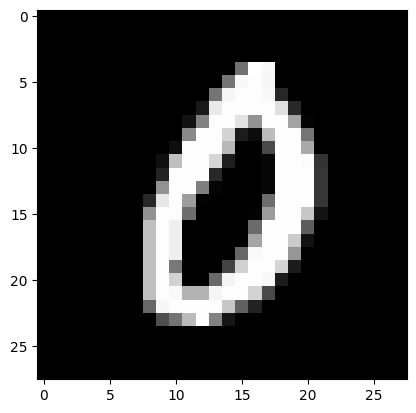

Image shape torch.Size([28, 28])
Label tensor(0)
Aspect ratio 0.7
Number of black regions 2.0
Eccentricity 0.759499675167631
Extent 0.6035714285714285
Edge density 31.224489795918366
Circularity 16.908445114172334
Bounding Box Ratio: 0.9642857142857143
Distance from Center: 11.968069434419805
Radial Moments (Mean, Variance, Skewness): [11.96806943 12.19620832 -0.75905868]
Convexity: 0.9706666666666667
Skeleton Endpoints: 40.0
Skeleton Crossings: 53.0
Pixel Count: 615.0


In [35]:
image_id = 0

image = train_images_tensor[image_id].reshape(28, 28)

import matplotlib.pyplot as plt

plt.imshow(image, cmap="gray")
plt.show()

print("Image shape", image.shape)

print("Label", train_labels_tensor[image_id])
print("Aspect ratio", aspect_ratio_train[image_id])
print("Number of black regions", num_white_regions_train[image_id])
print("Eccentricity", eccentricity_train[image_id])
print("Extent", extent_train[image_id])
print("Edge density", edge_density_train[image_id])
print("Circularity", circularity_train[image_id])

print("Bounding Box Ratio:", bounding_box_ratio_train[image_id])
print("Distance from Center:", distance_from_center_train[image_id])
print("Radial Moments (Mean, Variance, Skewness):", radial_moments_train[image_id])
print("Convexity:", convexity_train[image_id])
print("Skeleton Endpoints:", skeleton_endpoints_train[image_id])
print("Skeleton Crossings:", skeleton_crossings_train[image_id])
print("Pixel Count:", pixel_count_train[image_id])


In [48]:
# Determine the number of new features
num_new_features = 9

features_train = np.zeros((num_train, 2 + num_new_features))
features_val = np.zeros((num_val, 2 + num_new_features))
features_test = np.zeros((num_test, 2 + num_new_features))

# Processing the training dataset
for i in range(num_train):
    radial_features = radial_moments_train[i]  # this is assumed to be a tuple or list
    new_features = [
        bounding_box_ratio_train[i],
        distance_from_center_train[i],
        *radial_features,  # unpack the tuple or list
        convexity_train[i],
        skeleton_endpoints_train[i],
        skeleton_crossings_train[i],
        pixel_count_train[i]
    ]
    features_train[i, :] = np.hstack(
        (aspect_ratio_train[i], num_white_regions_train[i], new_features)
    )

# Processing the validation dataset
for i in range(num_val):
    radial_features = radial_moments_val[i]  # assuming similar structure as train
    new_features = [
        bounding_box_ratio_val[i],
        distance_from_center_val[i],
        *radial_features,
        convexity_val[i],
        skeleton_endpoints_val[i],
        skeleton_crossings_val[i],
        pixel_count_val[i]
    ]
    features_val[i, :] = np.hstack(
        (aspect_ratio_val[i], num_white_regions_val[i], new_features)
    )

# Processing the test dataset
for i in range(num_test):
    radial_features = radial_moments_test[i]  # assuming similar structure as train
    new_features = [
        bounding_box_ratio_test[i],
        distance_from_center_test[i],
        *radial_features,
        convexity_test[i],
        skeleton_endpoints_test[i],
        skeleton_crossings_test[i],
        pixel_count_test[i]
    ]
    features_test[i, :] = np.hstack(
        (aspect_ratio_test[i], num_white_regions_test[i], new_features)
    )


In [50]:
print(features_train[0])

[  0.7          2.           0.96428571  11.96806943  11.96806943
  12.19620832  -0.75905868   0.97066667  40.          53.
 615.        ]


In [51]:
train_features_normalized = torch.tensor(scaler.fit_transform(features_train))
val_features_normalized = torch.tensor(scaler.transform(features_val))
test_features_normalized = torch.tensor(scaler.transform(features_test))

In [52]:
train_features_normalized = train_features_normalized.float()
val_features_normalized = val_features_normalized.float()
test_features_normalized = test_features_normalized.float()

## Try out a neural network, on the new 20x20 dataset

In [57]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=5, random_state=0)
clf.fit(train_features_normalized, train_labels_tensor)

DecisionTreeClassifier(max_depth=5, random_state=0)

In [58]:
import numpy as np

num_test_samples = len(test_features_normalized)
python_predictions = clf.predict(test_features_normalized)
python_accuracy = np.sum(python_predictions == test_labels) / num_test_samples
print(f"Python accuracy: {100*python_accuracy} %")

Python accuracy: 56.11000000000001 %


In [59]:
importances = clf.feature_importances_
print(importances)

[3.08131283e-04 1.29506564e-01 0.00000000e+00 0.00000000e+00
 4.09134592e-04 5.02246077e-02 2.92511197e-02 3.99538331e-01
 3.74573908e-01 1.61882047e-02 0.00000000e+00]


In [63]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=20, max_depth=11, random_state=0)

# Fit the classifier to the training data
rf_clf.fit(train_features_normalized, train_labels_tensor)


RandomForestClassifier(max_depth=11, n_estimators=20, random_state=0)

In [64]:
python_predictions = rf_clf.predict(test_features_normalized)
python_accuracy = np.sum(python_predictions == test_labels) / num_test_samples
print(f"Python accuracy: {100*python_accuracy} %")

Python accuracy: 70.16 %


In [67]:
# define code to measure accuracy

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score


def evaluate_model(model, resized=False):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        if not resized:
            test_outputs = model(test_features_normalized)
        else:
            test_outputs = model(test_features_resized_normalized)
        _, predicted = torch.max(test_outputs.data, 1)
        accuracy = accuracy_score(test_labels, predicted.numpy())
        print("Accuracy:", accuracy)
        return accuracy

In [68]:
# Define the PyTorch neural network
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Hyperparameters
input_dim = train_features_normalized.shape[1]
output_dim = len(set(train_labels))  # Assuming train_labels are class indices
hidden_dim = int((input_dim + output_dim) / 2)

# Instantiate the model
model_medium2 = SimpleNN(
    input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_medium2.parameters(), lr=0.001)

# Training loop with L1 regularization
lambda_l1 = 0.0001  # L1 regularization coefficient

validation_losses = []
epoch = 0

model_states = []

while True:
    optimizer.zero_grad()
    outputs = model_medium2(train_features_normalized)

    loss = criterion(outputs, train_labels_tensor)

    # Add L1 regularization
    l1_reg = torch.tensor(0.0, requires_grad=True)
    for param in model_medium2.parameters():
        l1_reg = l1_reg + torch.norm(param, 1)
    loss += lambda_l1 * l1_reg

    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 100 == 0:
        print(
            f"Epoch [{epoch + 1}], Loss: {loss.item():.4f}, validation loss: {validation_losses[-1]:.4f}"
        )

    # store model state
    model_states.append(model_medium2.state_dict())

    # Compute validation loss
    with torch.no_grad():
        outputs = model_medium2(val_features_normalized)
        loss = criterion(outputs, validation_labels_tensor)
        validation_losses.append(loss.item())

    # Check for early stopping if no improvement in validation loss in last 10 epochs
    if epoch > 10 and validation_losses[-1] > validation_losses[-10]:
        print("Early stopping")
        break

    epoch += 1

best_model_state = model_states[np.argmin(validation_losses)]
model_medium2.load_state_dict(best_model_state)

evaluate_model(model_medium2)

Epoch [100], Loss: 1.9887, validation loss: 1.9886
Epoch [200], Loss: 1.6003, validation loss: 1.6058
Epoch [300], Loss: 1.3646, validation loss: 1.3744
Epoch [400], Loss: 1.2223, validation loss: 1.2316
Epoch [500], Loss: 1.1380, validation loss: 1.1462
Epoch [600], Loss: 1.0850, validation loss: 1.0911
Epoch [700], Loss: 1.0449, validation loss: 1.0490
Epoch [800], Loss: 1.0118, validation loss: 1.0140
Epoch [900], Loss: 0.9833, validation loss: 0.9837
Epoch [1000], Loss: 0.9590, validation loss: 0.9577
Epoch [1100], Loss: 0.9382, validation loss: 0.9353
Epoch [1200], Loss: 0.9209, validation loss: 0.9169
Epoch [1300], Loss: 0.9071, validation loss: 0.9027
Epoch [1400], Loss: 0.8957, validation loss: 0.8917
Epoch [1500], Loss: 0.8864, validation loss: 0.8829
Epoch [1600], Loss: 0.8784, validation loss: 0.8754
Epoch [1700], Loss: 0.8715, validation loss: 0.8688
Epoch [1800], Loss: 0.8654, validation loss: 0.8629
Epoch [1900], Loss: 0.8599, validation loss: 0.8575
Epoch [2000], Loss: 0

0.74